In [1]:
import numpy as np
import torch
from torch import optim
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching
from inference.flows.flow_types.plannar import PlanarFlow
from inference.flows.flow_types.neural_spine import NeuralSpineFlow
from inference.flows.flow_types.radial import RadialFlow

In [2]:
sns.set()

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
class Loss:
    
    @staticmethod
    def __call__(flow, obs, n_sample):
        
        z0 = flow.sample_base_dist(n_sample)
        zk, log_q0, log_sum_det = flow(z0) # shape: (n_sample, n_dim), (n_sample, ) (n_sample, ) 
            
        obs = obs.unsqueeze(-1) # shape: (n_obs, ) => (n_obs, 1)
    
        mu, log_var = zk.T
        sigma = torch.exp(0.5 * log_var)
        lls =  dist.Normal(mu, sigma).log_prob(obs).sum(axis=0)  # shape: (n_obs, n_sample) => (n_sample, )

        return (log_q0 - log_sum_det - lls).mean()

In [5]:
def generate_samples(flow, n_sample=1000):
    with torch.no_grad():
        z0 = flow.sample_base_dist(n_sample)  
        zk, prior_logprob, log_det = flow(z0)
    mu_samples, log_var_samples = zk.T
    return mu_samples, log_var_samples

In [6]:
def plot_results(mu_samples, log_var_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha_scatter=0.3, 
                 alpha_pdf=0.1):
    
    true_log_var = np.log(true_sigma**2)
    obs_log_var = np.log(obs_sigma**2)
    
    sigma_samples = torch.exp(0.5*log_var_samples)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.set_title("Unconstrained space")
    ax.scatter(mu_samples, log_var_samples, alpha=alpha_scatter, color="C1")
    ax.scatter(true_mu, true_log_var, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_log_var, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\ln \sigma^2$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100).unsqueeze(0)
    
    pdf_true = dist.Normal(true_mu, true_sigma).log_prob(x).exp()
    pdf_sample = dist.Normal(mu_samples, sigma_samples).log_prob(x.unsqueeze(-1)).exp()

    ax.plot(x.squeeze(), pdf_sample.squeeze(), color="C1", alpha=alpha_pdf, label='inferred')
    ax.plot(x.squeeze(), pdf_true.squeeze(), color='C0', label="theoretic")
    # ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
    #         color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

In [7]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [8]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [9]:
n_dim = 2

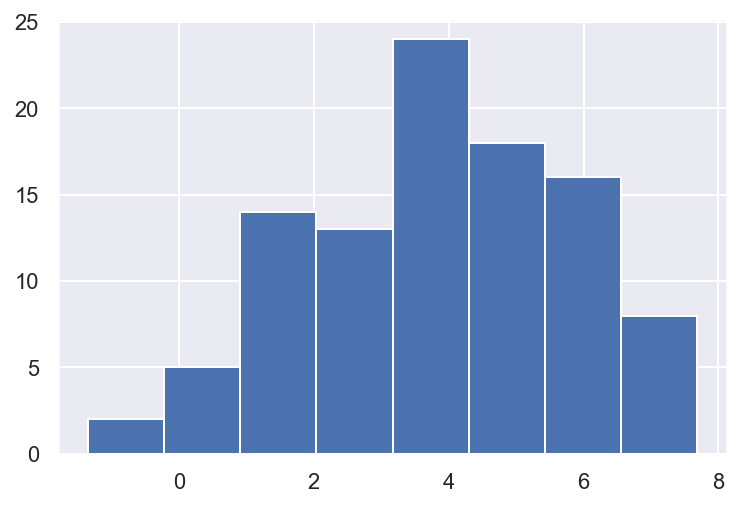

In [10]:
fig, ax = plt.subplots()
ax.hist(obs.data.numpy(), bins='auto');

# Full batch

In [11]:
def train_full_batch(
        obs,
        flow_model,
        flow_length=16,
        epochs=1000,
        initial_lr=0.01,
        n_sample=40,
        freq_update_loss=50,):
    
    flow = NormalizingFlow(dim=n_dim, flow_length=flow_length,
                          flow_model=flow_model)

    loss_func = Loss()

    optimizer = optim.Adam(
        flow.parameters(),
        lr=initial_lr)

    hist_loss = np.zeros(epochs)

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()
            loss = loss_func(flow=flow,
                             obs=obs,
                             n_sample=n_sample)
            loss.backward()
            optimizer.step()

            hist_loss[i] = loss.item()

            if i % freq_update_loss == 0 and i > 0:
                pbar.set_postfix(
                    {'loss': np.mean(hist_loss[i - freq_update_loss:i])})
            pbar.update()

    return flow, hist_loss

In [12]:
flow, hist_loss = train_full_batch(obs, flow_model=RadialFlow,
                                   initial_lr=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

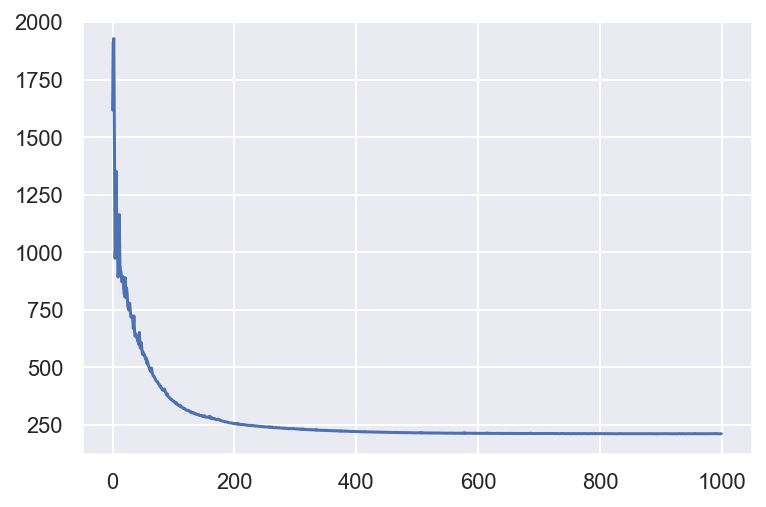

In [13]:
plt.plot(hist_loss);

In [14]:
mu_samples, log_var_samples = generate_samples(flow, n_sample=500)

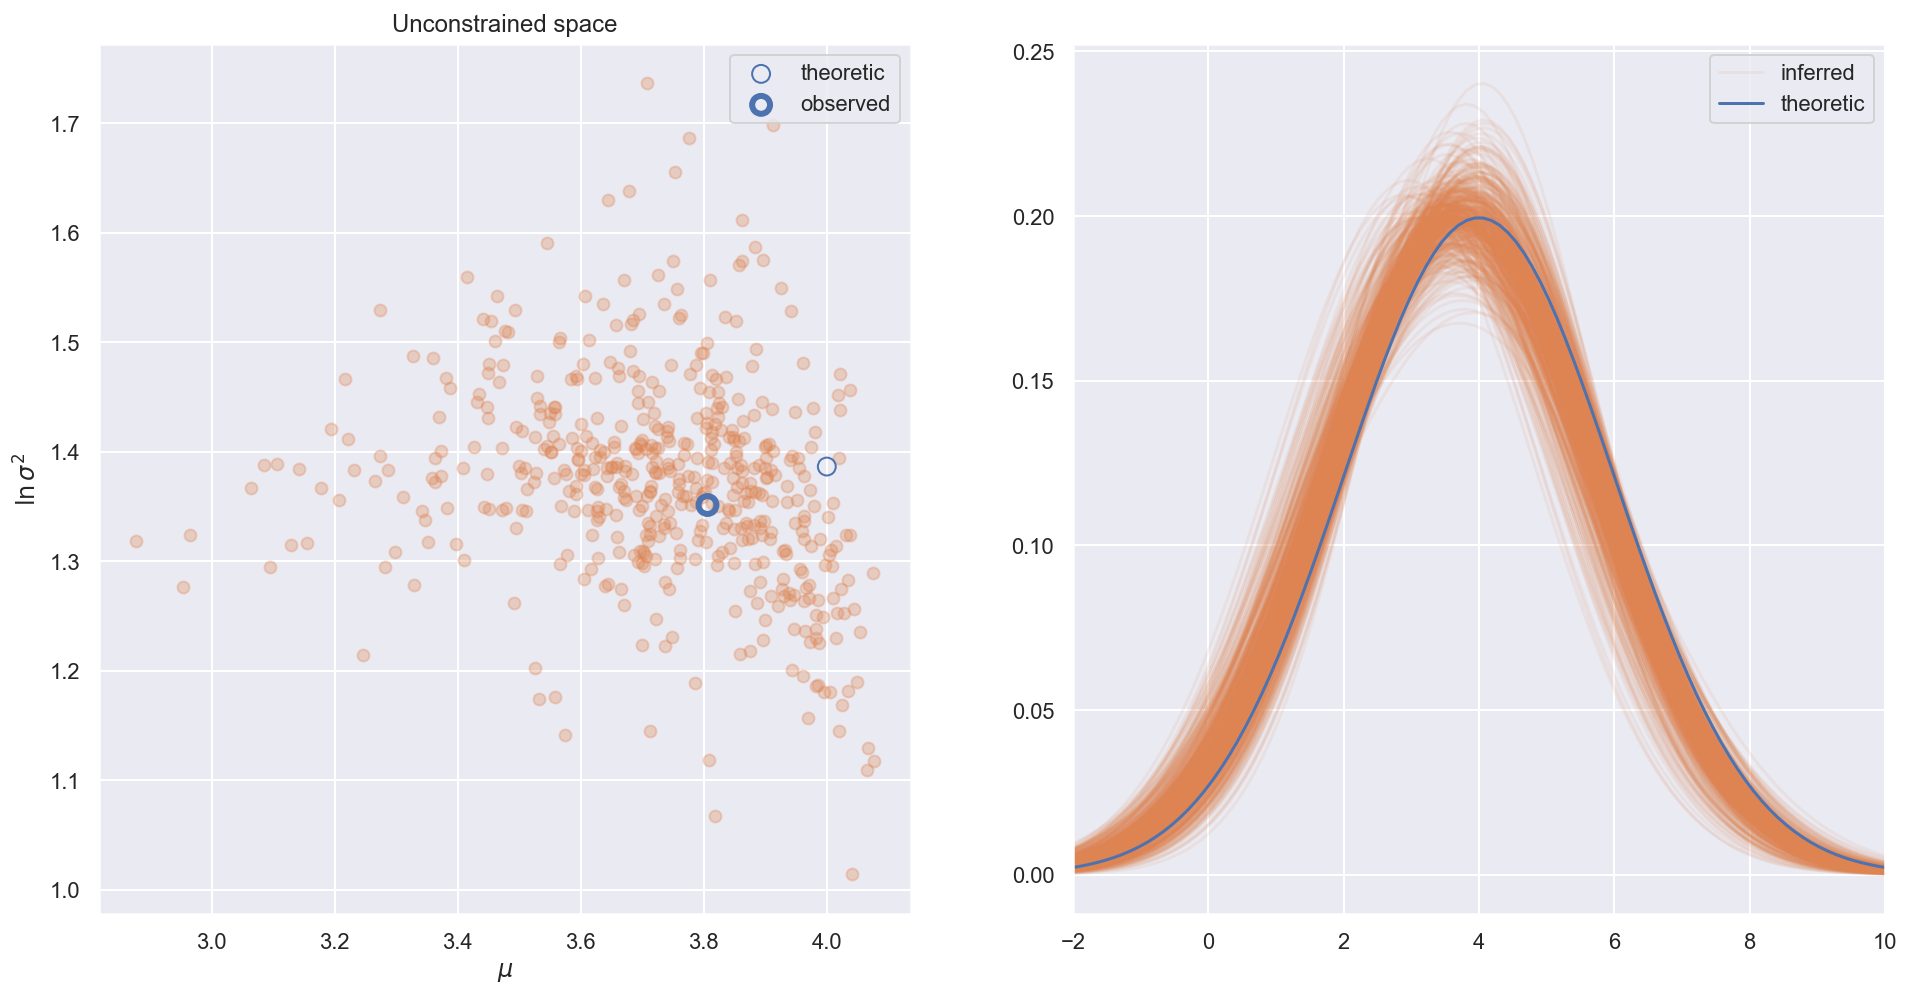

In [15]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)

# Minibatch

In [22]:
def train_minibatch(obs, flow_model, batch_size=10, epochs=1000, flow_length=16, 
                    initial_lr=0.005, n_sample=40, seed=123):
    
    torch.manual_seed(seed)

    flow = NormalizingFlow(dim=n_dim, flow_length=flow_length, flow_model=flow_model)

    loss_func = Loss()

    optimizer = optim.Adam(
        flow.parameters(),
        lr=initial_lr)

    hist_loss = []

    with tqdm(total=epochs) as pbar:

        for epoch in range(epochs):

            permutation = torch.randperm(n_obs)

            for i in range(0, n_obs, batch_size):

                indices = permutation[i:i+batch_size]

                minibatch = obs[indices]
                optimizer.zero_grad()
                loss = loss_func(flow=flow,
                                 obs=minibatch,
                                 n_sample=n_sample)
                loss.backward()
                optimizer.step()
                
                hist_loss.append(loss.item())

            pbar.set_postfix(
                {'loss': np.mean(hist_loss[- batch_size:])})
            pbar.update()
    return flow, hist_loss

In [23]:
flow, hist_loss = train_minibatch(obs, batch_size=10, flow_model=RadialFlow, initial_lr=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

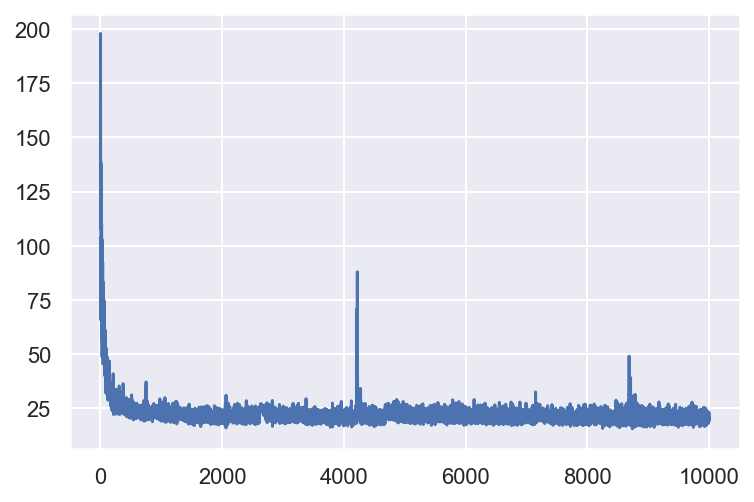

In [24]:
plt.plot(hist_loss);

In [25]:
mu_samples, log_var_samples = generate_samples(flow, 500)

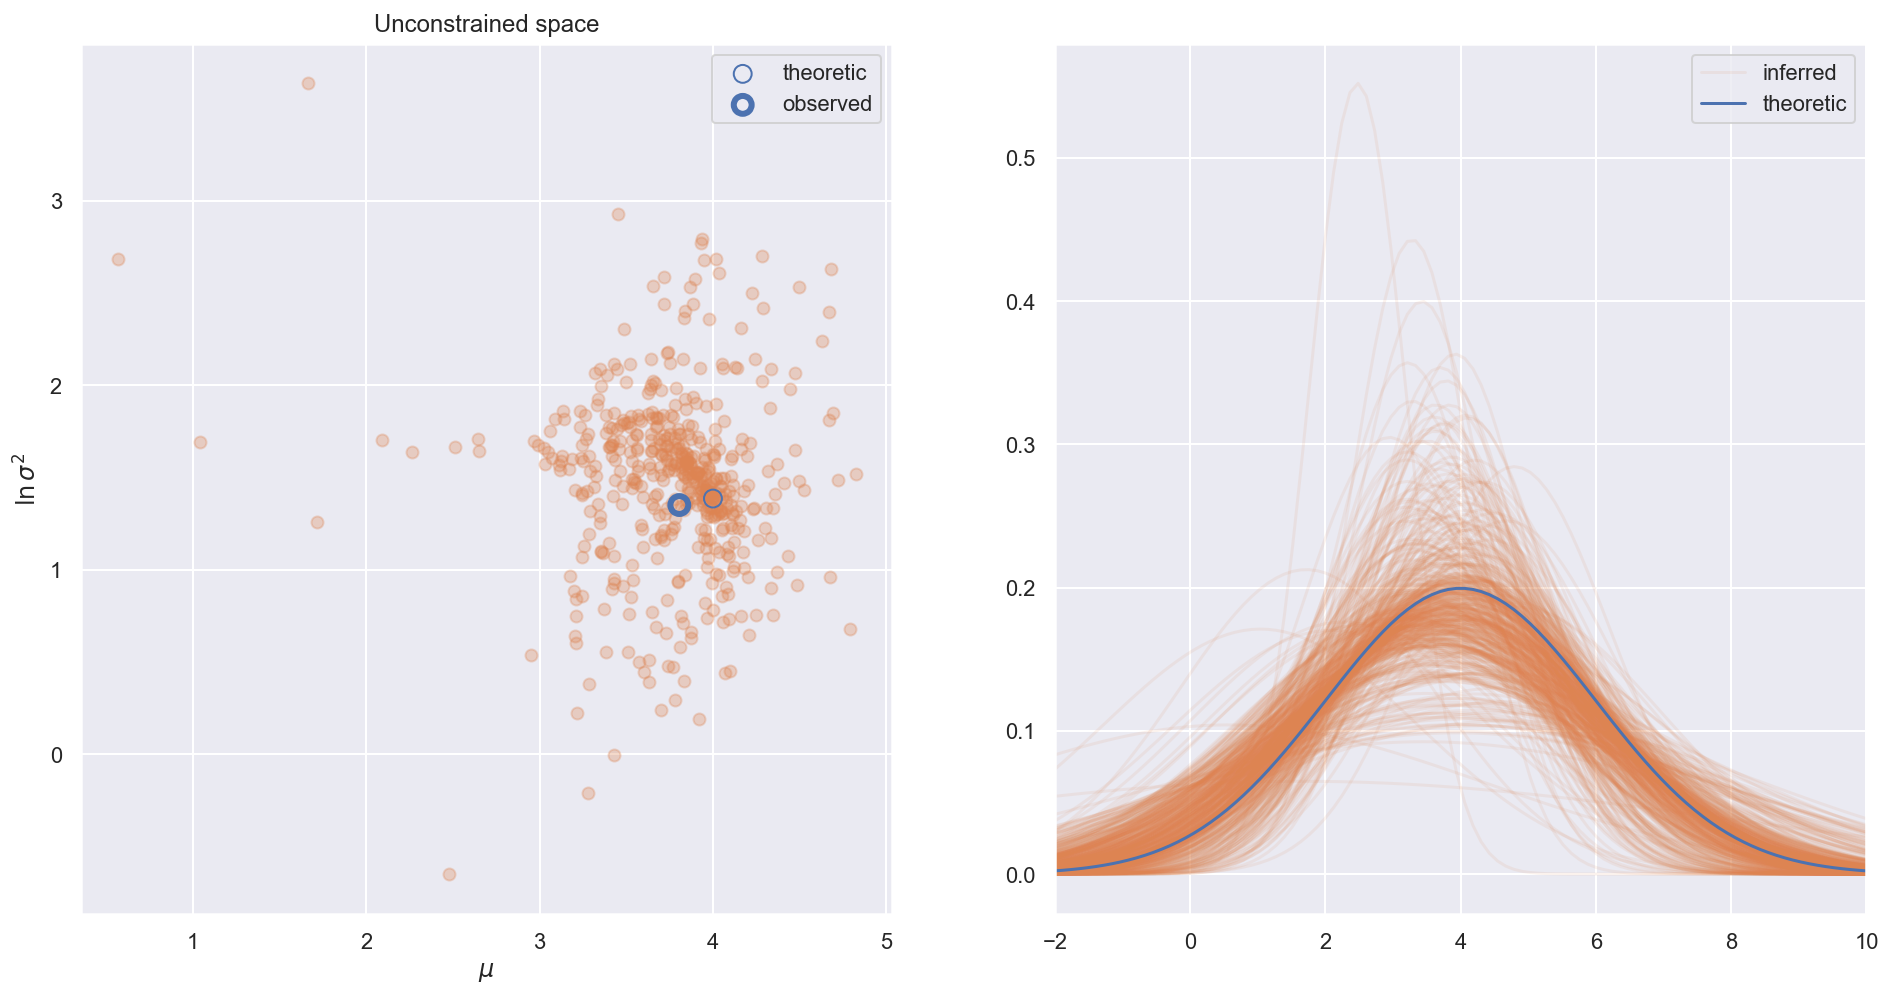

In [26]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=mu_samples, log_var_samples=log_var_samples)